In [1]:
import sys
sys.path.append('../src/') # for graph_data

import graph_data as gd
import time
import torch
from models import TreeSupport
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import random_split, ConcatDataset
from torch_geometric.data import DataLoader
from Bio import Phylo as phy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('text', usetex=True)

torch.manual_seed(245)

# Datasets
## Prepare trees and reconstructed sequences

In [2]:
data_path = '../data/'

In [3]:
target_tree = phy.read(data_path+'tree/Fungi45_infer/Fungi.tre', 'newick')
#all_data = gd.Trees.load_ready_trees(data_path+'tree/Fungi45_infer/fml_output/', data_path+'tree/Fungi45_infer/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS
fungi_data = gd.Trees(data_path+'tree/Fungi45_infer/', data_path+'alns/Fungi45/', target_tree)
fungi_data.data.x = fungi_data.data.x.float()
fungi_data.data.edge_attr = (torch.max(fungi_data.data.edge_attr)+0.001 - fungi_data.data.edge_attr).float()
fungi_data.data.edge_index = fungi_data.data.edge_index.long()

In [4]:
target_tree = phy.read(data_path+'tree/Archaea/Archaea.tre', 'newick')
#archaea_data = gd.Trees.load_ready_trees(data_path+'tree/Archaea/fml_output/', data_path+'tree/Archaea/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS //delete temp_tree
archaea_data = gd.Trees(data_path+"tree/Archaea/", data_path+"alns/Archaea/", target_tree)
archaea_data.data.x = archaea_data.data.x.float()
archaea_data.data.edge_attr = (torch.max(archaea_data.data.edge_attr)+0.001 - archaea_data.data.edge_attr).float()
archaea_data.data.edge_index = archaea_data.data.edge_index.long()

In [5]:
# concatenate datasets
all_data =  ConcatDataset([fungi_data, archaea_data])

In [6]:
# data preparation
train_batch = 50
test_batch = 50
# data loaders
train, test = random_split(
    all_data, [round(len(all_data) * 0.8), round(len(all_data) * 0.2)]
)

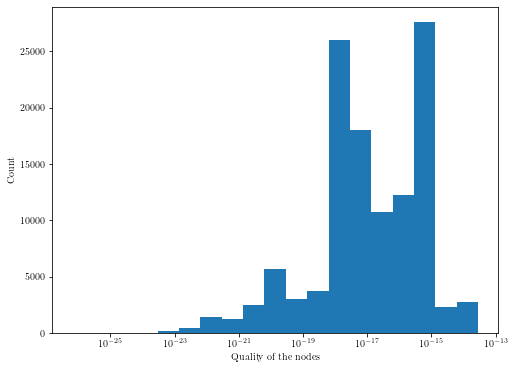

In [7]:
lst = list()
for i, data in enumerate(train):
    nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
    internodes = nodes[0, nodes[1]!=1]
    lst += data.y[internodes].squeeze().tolist()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xscale('log')
logbins = np.geomspace(min(lst), max(lst), 20)
plt.hist(lst, bins=logbins)
ax.set_xlabel('Quality of the nodes')
ax.set_ylabel('Count')
plt.savefig('quality.png')

In [8]:
train_dl = DataLoader(
    train, batch_size=train_batch, pin_memory=True, num_workers=3
)
test_dl = DataLoader(
    test, batch_size=test_batch, num_workers=2
)

In [9]:
model = TreeSupport(231, 400)
model = model.cuda()
silent = False
num_epochs = 400
loss_fn = MSELoss()
test_batches = len(test_dl)
# stattr
losses = []
val_losses = []
learning_rates = []

In [10]:
# interactive descending lr for less loss
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, verbose=True, cooldown=2, patience=5
)
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for data in train_dl:
        data = data.to(torch.device('cuda'))
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()

        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = 0
    with torch.autograd.no_grad():
        for data in test_dl:
            data = data.to(torch.device('cuda'))
            out = model(data)
            agg_loss += loss_fn(out, data.y)
        val_losses.append(agg_loss.item()/test_batches)
    scheduler.step(agg_loss)
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )

Epoch [1/400], Loss (last training batch/val): 0.2446/0.2441. Time elapsed: 2.42
Epoch [2/400], Loss (last training batch/val): 0.2206/0.2234. Time elapsed: 4.49
Epoch [3/400], Loss (last training batch/val): 0.1911/0.1887. Time elapsed: 6.57
Epoch [4/400], Loss (last training batch/val): 0.1746/0.1661. Time elapsed: 8.65
Epoch [5/400], Loss (last training batch/val): 0.1509/0.1567. Time elapsed: 10.71
Epoch [6/400], Loss (last training batch/val): 0.1375/0.1429. Time elapsed: 12.77
Epoch [7/400], Loss (last training batch/val): 0.1279/0.1334. Time elapsed: 14.86
Epoch [8/400], Loss (last training batch/val): 0.1224/0.1202. Time elapsed: 16.93
Epoch [9/400], Loss (last training batch/val): 0.1162/0.1120. Time elapsed: 18.99
Epoch [10/400], Loss (last training batch/val): 0.1064/0.1049. Time elapsed: 21.07
Epoch [11/400], Loss (last training batch/val): 0.1016/0.0998. Time elapsed: 23.14
Epoch [12/400], Loss (last training batch/val): 0.0968/0.0954. Time elapsed: 25.24
Epoch [13/400], L

# Learning stats

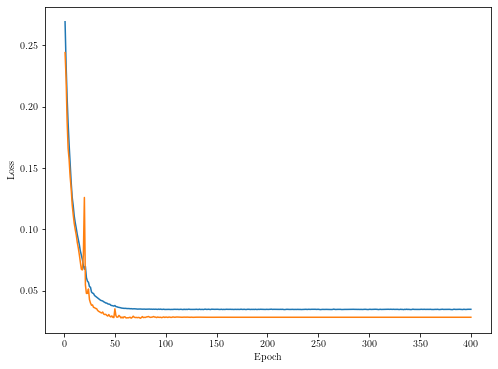

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(
    range(1, len(val_losses)+1), 
    list(map(
        lambda i: np.mean(losses[i:i+len(train_dl)]),
        range(0, len(losses)-len(train_dl)+1, len(train_dl))
    ))
)
plt.plot(range(1, len(val_losses)+1), val_losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('loss.png')

In [12]:
torch.save(model.state_dict(), '../models/NewTry2.dct')

## Test with completely different data

In [13]:
from sklearn import metrics

In [14]:
# data
target_tree = phy.read(data_path+'tree/Other_eukaryota_2018.tre', 'newick')
test_dataset = gd.Trees(
    data_path+"tree/Eukaryota/",
    data_path+"alns/other_eukaryota_2018/",
    target_tree
)
# transform to feed into the model
test_dataset.data.x = test_dataset.data.x.float()
test_dataset.data.edge_attr = (torch.max(test_dataset.data.edge_attr)+0.001 - test_dataset.data.edge_attr).float()
test_dataset.data.edge_index = test_dataset.data.edge_index.long()
test_dl = DataLoader(
    test_dataset, batch_size=test_batch, num_workers=2
)

In [15]:
nplist = list()
for data in test_dataset:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nodes = torch.stack(torch.unique(data.edge_index[0], return_counts=True))
        internodes = nodes[0, nodes[1]!=1]
        nplist.append(np.concatenate([data.y[internodes].cpu().numpy(), out[internodes].detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

,actual,predicted
count,1.340500e+05,134050.000000
mean,5.657991e-03,0.106296
std,5.977007e-02,0.189134
min,1.925930e-34,0.000000
25%,5.960464e-08,0.000000
50%,6.103516e-05,0.000000
75%,9.765625e-04,0.132873
max,1.000000e+00,1.666440


In [16]:
test_results = pd.DataFrame(np.concatenate(nplist), columns=['actual', 'predicted'])

# Further assessment

ROC 

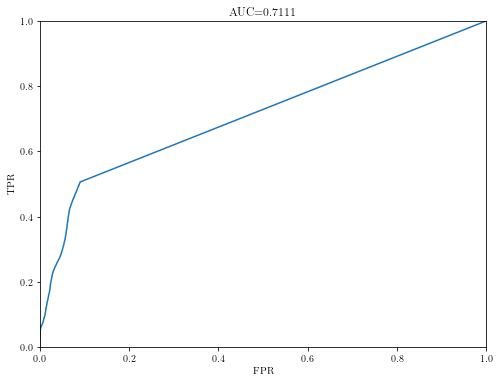

In [27]:
thr = test_results["actual"].median()
fpr, tpr, thresholds_roc = metrics.roc_curve(test_results["actual"]>=thr, test_results["predicted"])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(fpr, tpr)
plt.title('AUC={:.4f}'.format(metrics.roc_auc_score(test_results["actual"]>=thr, test_results["predicted"])))
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.savefig('roc.png')

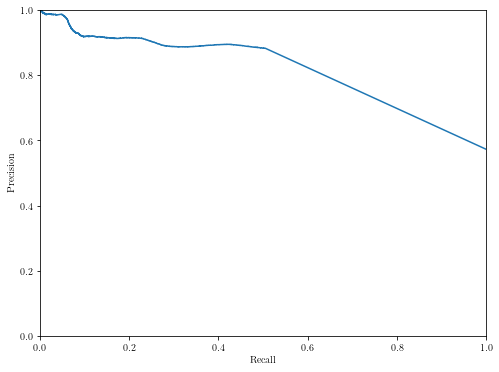

In [26]:
prec, rec, thresholds_recprec = metrics.precision_recall_curve(test_results["actual"]>=thr, test_results["predicted"])
roc_data = pd.DataFrame({"Precision": prec, "Recall": rec})
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(rec, prec)
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.savefig('recprec.png')

In [19]:
optimal_thr = thresholds_roc[np.argmax(tpr-fpr)]

In [20]:
optimal_thr

1.3113022e-05

In [21]:
metrics.confusion_matrix(test_results["actual"]>=thr, test_results["predicted"]>=optimal_thr)

array([[52082,  5199],
       [37886, 38883]])

In [22]:
fpr[np.argmax(tpr-fpr)]

0.0907630802534872

In [23]:
tpr[np.argmax(tpr-fpr)]

0.5064935064935064

In [24]:
optimal_thr_pr = thresholds_recprec[np.argmax(prec-rec)]

IndexError: index 43786 is out of bounds for axis 0 with size 43786